In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import datetime
import os

In [15]:
df = pd.read_csv('/content/supply_chain_data.csv')

In [16]:
data.head()

,Product type,SKU,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,Lead times,Order quantities,...,Location,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs
0,haircare,SKU0,69.808006,55,802,8661.996792,Non-binary,58,7,96,...,Mumbai,29,215,29,46.279879,Pending,0.226410,Road,Route B,187.752075
1,skincare,SKU1,14.843523,95,736,7460.900065,Female,53,30,37,...,Mumbai,23,517,30,33.616769,Pending,4.854068,Road,Route B,503.065579
2,haircare,SKU2,11.319683,34,8,9577.749626,Unknown,1,10,88,...,Mumbai,12,971,27,30.688019,Pending,4.580593,Air,Route C,141.920282
3,skincare,SKU3,61.163343,68,83,7766.836426,Non-binary,23,13,59,...,Kolkata,24,937,18,35.624741,Fail,4.746649,Rail,Route A,254.776159
4,skincare,SKU4,4.805496,26,871,2686.505152,Non-binary,5,3,56,...,Delhi,5,414,3,92.065161,Fail,3.145580,Air,Route A,923.440632


In [17]:
data = data.dropna()

In [18]:
TARGET_COL = 'Number of products sold'


In [19]:
start_date = datetime.date(2023, 1, 1)
df['Date'] = [start_date + datetime.timedelta(days=i) for i in range(len(df))]


In [21]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Day_of_Week'] = df['Date'].dt.dayofweek
df['Quarter'] = df['Date'].dt.quarter

In [22]:
df = df.drop('Date', axis=1)

In [23]:
X = df.drop(columns=[TARGET_COL, 'SKU', 'Revenue generated']) # SKU is an ID, Revenue is calculated from Price*Sold
y = df[TARGET_COL]


In [24]:
categorical_features = X.select_dtypes(include=['object', 'int64']).columns.tolist()

In [25]:
numerical_features = X.select_dtypes(include=['float64']).columns.tolist()

In [26]:
features_to_keep = [
    'Price', 'Availability', 'Stock levels', 'Order quantities',
    'Shipping times', 'Shipping costs', 'Lead time', 'Production volumes',
    'Manufacturing lead time', 'Manufacturing costs', 'Defect rates',
    'Month', 'Day_of_Week', 'Quarter', 'Product type',
    'Customer demographics', 'Shipping carriers', 'Supplier name',
    'Location', 'Inspection results', 'Transportation modes', 'Routes'
]
X = X[features_to_keep]

In [27]:
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

In [29]:
X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)


In [30]:
y_train = y_train.to_numpy().reshape(-1, 1)
y_test = y_test.to_numpy().reshape(-1, 1)


In [31]:
print(f"Training data shape: {X_train.shape}, Target shape: {y_train.shape}")

Training data shape: (80, 44), Target shape: (80, 1)


In [32]:
input_dim = X_train.shape[1]

In [33]:
model = Sequential([
    # Input Layer (and first hidden layer)
    Dense(128, activation='relu', input_shape=(input_dim,)),
    # Second Hidden Layer
    Dense(64, activation='relu'),
    # Third Hidden Layer
    Dense(32, activation='relu'),
    # Output Layer (1 node for the predicted 'Number of products sold')
    Dense(1)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
model.compile(optimizer='adam', loss='mse')

In [35]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,129 (63.00 KB)

 Trainable params: 16,129 (63.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [36]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2, # 20% validation split
    verbose=0 # Set to 1 to see progress
)

In [37]:
print("\nModel training complete (50 epochs).")



Model training complete (50 epochs).



Model Evaluation (Mean Squared Error on Test Set): 133195.33


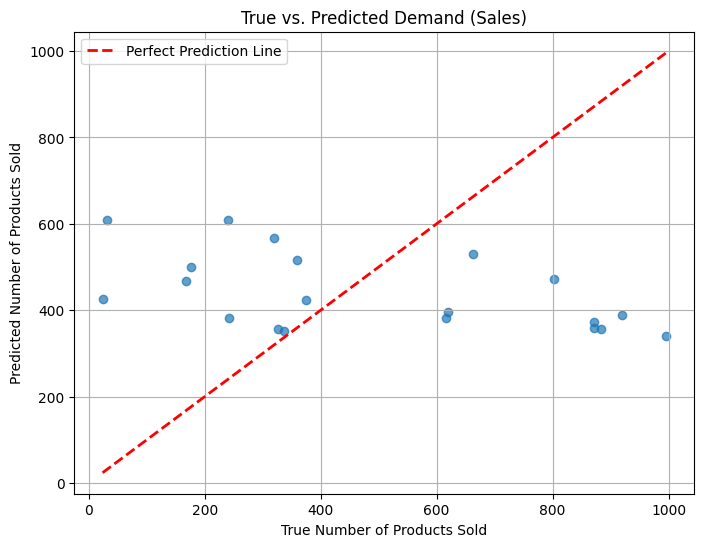


Final Report Value: MSE_value is now set to 133195.33


In [38]:
mse_test = model.evaluate(X_test, y_test, verbose=0)
mse_value = round(mse_test, 2)
print(f"\nModel Evaluation (Mean Squared Error on Test Set): {mse_value}")

y_pred = model.predict(X_test, verbose=0)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction Line')
plt.title('True vs. Predicted Demand (Sales)')
plt.xlabel('True Number of Products Sold')
plt.ylabel('Predicted Number of Products Sold')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nFinal Report Value: MSE_value is now set to {mse_value}")

In [39]:
model_filename = 'demand_forecasting_nn_model.h5'
model.save(model_filename)
print(f"\nTrained model saved as: {model_filename}")
new_data_point = X.iloc[[0]].copy()
new_data_point['Price'] = 50.0
new_data_point['Availability'] = 80
new_data_point['Stock levels'] = 100
new_data_point['Order quantities'] = 50
new_data_processed = preprocessor.transform(new_data_point)
new_prediction = model.predict(new_data_processed, verbose=0)[0][0]
print("\n--- Example Prediction ---")
print(f"Input Features (Sample): {new_data_point.values[0]}")
print(f"The model forecasts a demand of approximately: {int(round(new_prediction))} units.")


Trained model saved as: demand_forecasting_nn_model.h5

--- Example Prediction ---
Input Features (Sample): [50.0 80 100 50 4 2.956572139430807 29 215 29 46.27987924050832
 0.2264103608499251 1 6 1 'haircare' 'Non-binary' 'Carrier B' 'Supplier 3'
 'Mumbai' 'Pending' 'Road' 'Route B']
The model forecasts a demand of approximately: 450 units.
